In [1]:
import plotly.graph_objects as go
import torch
from plotly.subplots import make_subplots
from torchfem import Planar
from torchfem.elements import Quad1, Tria1
from torchfem.materials import IsotropicPlaneStress

## Shape functions of a triangle element

In [2]:
# Define a triangle element
tria = Tria1()

# Define the domain
x1 = torch.linspace(0, 1, steps=100)
x2 = torch.linspace(0, 1, steps=100)
x = torch.stack(torch.meshgrid(x1, x2, indexing="xy"), dim=2)
mask = x[..., 0] + x[..., 1] > 1.0
x[mask, :] = torch.nan

# Plot the shape functions
fig = make_subplots(
    rows=1,
    cols=3,
    horizontal_spacing=0.0,
    vertical_spacing=0.0,
    specs=[
        [{"type": "surface"}, {"type": "surface"}, {"type": "surface"}],
    ],
)
fig.add_trace(go.Surface(z=tria.N(x)[..., 0], x=x1, y=x2), row=1, col=1)
fig.add_trace(go.Surface(z=tria.N(x)[..., 1], x=x1, y=x2), row=1, col=2)
fig.add_trace(go.Surface(z=tria.N(x)[..., 2], x=x1, y=x2), row=1, col=3)
fig.update_traces(showscale=False)
fig.update_layout(autosize=False, width=1200, height=400)
fig.update_scenes(
    xaxis_title_text="ξ1", yaxis_title_text="ξ2", zaxis_title_text="N(ξ,η)"
)
fig.show()

## Shape functions of a quadrilateral element

In [3]:
# Define a quadrilateral element
quad = Quad1()

# Define the domain
x1 = torch.linspace(-1, 1, steps=100)
x2 = torch.linspace(-1, 1, steps=100)
x = torch.stack(torch.meshgrid(x1, x2, indexing="xy"), dim=2)

# Plot the shape functions
fig = make_subplots(
    rows=2,
    cols=2,
    horizontal_spacing=0.0,
    vertical_spacing=0.0,
    specs=[
        [{"type": "surface"}, {"type": "surface"}],
        [{"type": "surface"}, {"type": "surface"}],
    ],
)
fig.add_trace(go.Surface(z=quad.N(x)[..., 0], x=x1, y=x2), row=1, col=1)
fig.add_trace(go.Surface(z=quad.N(x)[..., 1], x=x1, y=x2), row=1, col=2)
fig.add_trace(go.Surface(z=quad.N(x)[..., 2], x=x1, y=x2), row=2, col=1)
fig.add_trace(go.Surface(z=quad.N(x)[..., 3], x=x1, y=x2), row=2, col=2)
fig.update_traces(showscale=False)
fig.update_layout(autosize=False, width=800, height=800)
fig.update_scenes(
    xaxis_title_text="ξ1", yaxis_title_text="ξ2", zaxis_title_text="N(ξ,η)"
)
fig.show()

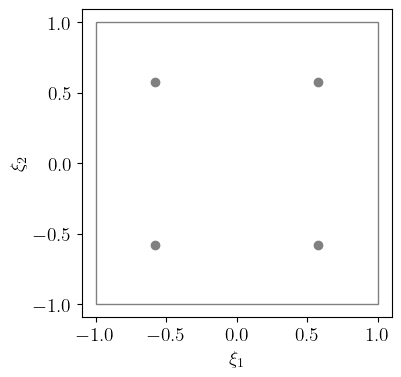

In [4]:
from math import sqrt

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

plt.rcParams["text.usetex"] = True
plt.rcParams["font.size"] = 14

fig = plt.figure(figsize=(4, 4))
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.scatter(
    [-1 / sqrt(3), -1 / sqrt(3), 1 / sqrt(3), 1 / sqrt(3)],
    [1 / sqrt(3), -1 / sqrt(3), -1 / sqrt(3), 1 / sqrt(3)],
    color="gray",
)
plt.gca().add_patch(Rectangle((-1, -1), 2, 2, fc="none", ec="gray"))
plt.axis("equal")
plt.xlabel("$\\xi_1$")
plt.ylabel("$\\xi_2$")
plt.savefig("../figures/reference_element.svg", transparent=True, bbox_inches="tight")

## Gauss-Legendre quadrature

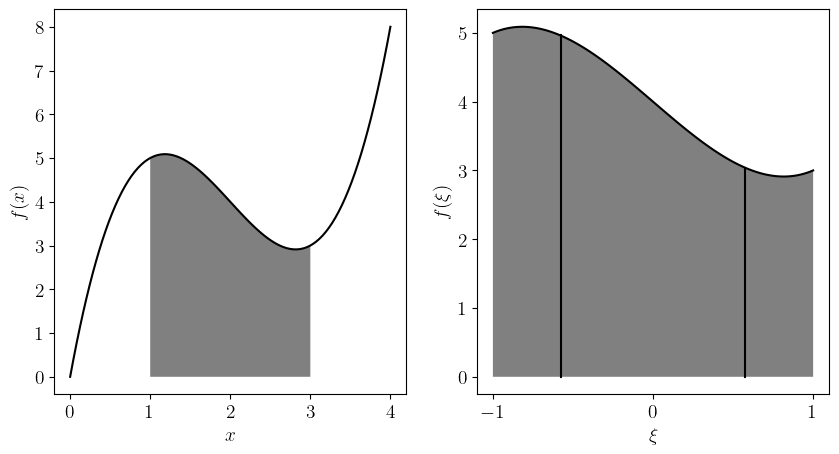

In [5]:
a = 1
b = 3


def f(x):
    return (x - 2) ** 3 - 2 * x + 8


def x(xi):
    return a + (b - a) / 2.0 * (1 + xi)


xv = torch.linspace(0, 4, 100)
x_int = torch.linspace(a, b, 100)
xi = torch.linspace(-1, 1, 100)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(xv, f(xv), "-k")
ax[0].fill_between(x_int, f(x_int), fc="gray")
ax[0].set_xlabel("$x$")
ax[0].set_ylabel("$f(x)$")
ax[1].plot(xi, f(x(xi)) * (b - a) / 2.0, "-k")
ax[1].plot(2 * [-1.0 / sqrt(3)], [0.0, f(x(-1.0 / sqrt(3)))], color="k")
ax[1].plot(2 * [1.0 / sqrt(3)], [0.0, f(x(1.0 / sqrt(3)))], color="k")
ax[1].fill_between(xi, f(x(xi)), fc="gray")
ax[1].set_xlabel("$\\xi$")
ax[1].set_ylabel("$f(\\xi)$")
ax[1].set_xticks([-1, 0, 1])
plt.savefig("../figures/gauss_legendre.svg", transparent=True, bbox_inches="tight")

## A simple cantilever example

In [6]:
def get_cantilever(size, Lx, Ly, d=1.0, E=100, nu=0.3, etype=Quad1()):
    # Material
    material = IsotropicPlaneStress(E, nu)

    # Dimensions
    Nx = int(Lx / size)
    Ny = int(Ly / size)

    # Create nodes
    n1 = torch.linspace(0.0, Lx, Nx + 1)
    n2 = torch.linspace(0.0, Ly, Ny + 1)
    n1, n2 = torch.stack(torch.meshgrid(n1, n2, indexing="xy"))
    nodes = torch.stack([n1.ravel(), n2.ravel()], dim=1)

    # Create elements connecting nodes
    elements = []
    for j in range(Ny):
        for i in range(Nx):
            if isinstance(etype, Quad1):
                # Quad elements
                n0 = i + j * (Nx + 1)
                elements.append([n0, n0 + 1, n0 + Nx + 2, n0 + Nx + 1])
            else:
                # Tria elements
                n0 = i + j * (Nx + 1)
                elements.append([n0, n0 + 1, n0 + Nx + 2])
                elements.append([n0 + Nx + 2, n0 + Nx + 1, n0])
    elements = torch.tensor(elements)

    cantilever = Planar(nodes, elements, material)

    # Load at tip
    cantilever.forces[(int((Ny + 1) / 2) + 1) * (Nx + 1) - 1, 1] = -1.0

    # Constrained displacement at left end
    for i in range(Ny + 1):
        cantilever.constraints[i * (Nx + 1), :] = True

    # Default
    cantilever.thickness[:] = d

    return cantilever

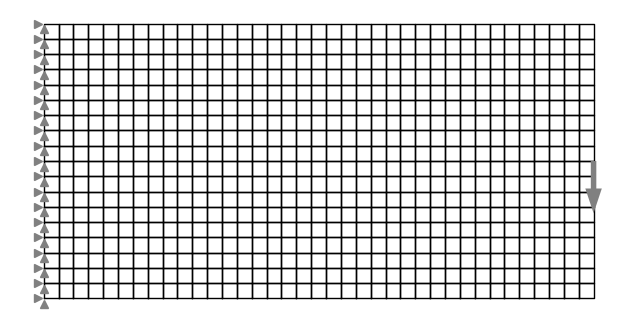

In [7]:
import matplotlib.pyplot as plt

# Define cantilever beam

cantilever = get_cantilever(0.75, 28.0, 14.0)
cantilever.plot()
plt.savefig("../figures/cantilever_fem.svg", transparent=True, bbox_inches="tight")

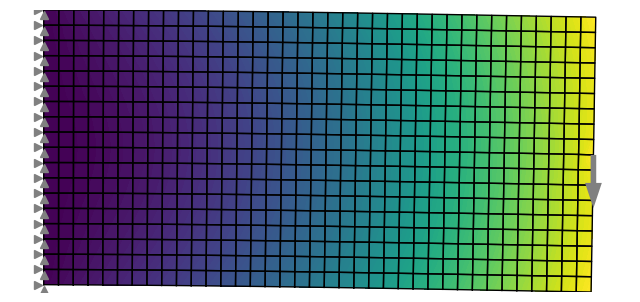

In [8]:
# Solve
u, f = cantilever.solve()
# Plot
cantilever.plot(u, node_property=torch.norm(u, dim=1))
plt.savefig(
    "../figures/cantilever_fem_solved.svg", transparent=True, bbox_inches="tight"
)

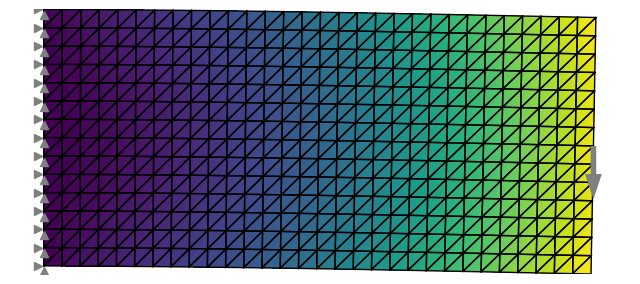

In [9]:
# Define cantilever beam with triangle elements
cantilever_tria = get_cantilever(1.0, 30.0, 14.0, etype=Tria1())

# Solve
u, f = cantilever_tria.solve()

# Plot
cantilever_tria.plot(u, node_property=torch.norm(u, dim=1), node_labels=True)